In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

## **以下のことを行う**
- 基底の数（信号源の数）は2とする

- データの読み込み(dat1.txt, dat2.txt)
  - 1行に1つのデータが入っている
  - dat1のデータとdat2のデータをそれぞれ縦に並べて、列ベクトルに格納し、これを２つ横に並べて行列Xを作る
    - 列ベクトルの要素数は、データの行数datasizeと同じ
- 観測データx_j(Xの第j列ベクトル)を以下の手順で無相関化(白色化)する
  - 列ベクトルの平均を0にする
  - 観測データ(列ベクトル)x_jの共分散行列(自己相関行列)を求め、jを変化させたときの期待値を取る
    - 共分散行列VarSigmaは、以下の式で求める
      - VarSigma = E[x_j * x_j^T]
  - 共分散行列VarSigmaを直交行列Eにより対角化する
  - 対角化した共分散行列Dの逆行列の平方根に、左から直交行列を、右からその転置をかけることで、新たな行列Vを求める
  - 観測データ(列ベクトル)にVをかけることで、無相関化されたデータ(列ベクトル)z_jを得る
    - z_jの共分散行列の期待値は、単位行列になることを確認する
- 続いて、観測データから信号源を与える行列Wを、以下の手順で求める。
  - 適当な行列Wを用意する
    - 従って行列のサイズは、N×Nとする
  - Wを行ベクトル(N次元)ごとに正規化する
  - Wの行ベクトルを更新する(第i行ベクトルを更新する)
    - Wの第i行ベクトルを転置したもの(N次元列ベクトル)をwt_iとする
    - 列ベクトルwt_iを以下の式で更新する
      - wt_i = E[z_j * (wt_i^T * z_j)^3] - 3 * wt_i
      - E[]はjを変化させたときの期待値を表す
    - 更新したwt_iを正規化する
    - wt_iが更新により変化しなくなったら、Wの第i行ベクトルをwt_iの転置とし、変化している場合は、更新を続ける
- Wを用いて、観測データから信号源を推定する
  - 推定した信号源を行列Signal_jとする
  - signal_j = W * z_j
- 以上の手順を、信号源の数だけ繰り返す
- Sの各行ベクトルを、グラフにプロットする

In [104]:
# - データの読み込み(dat1.txt, dat2.txt)
#   - 1行に1つのデータが入っている
#   - dat1とdat2の同時刻の(j行目の)データを縦に並べて、列ベクトルx_jに格納し、これを横に並べて行列Xを作る
#     - 列ベクトルの要素数は、2


f1 = open('data/dat1.txt')
f2 = open('data/dat2.txt')
X = np.array([np.array([float(f1.readline()), float(f2.readline())]) for i in range(1000)])
# X = X.T
# type(X)
# datanum, datasize = X.shape
datasize, datanum = X.shape
datasize

1000

In [ ]:
X[:,0]

In [108]:
# 対称行列の直交行列による対角化
def Eigenvalue_decomp(A):
    # A: 対称行列
    # return: 対角化された対称行列D, 直交行列E
    # A = EDE^T
    # D: 対角行列
    # E: 直交行列
    # D = np.zeros(A.shape)
    # E = np.zeros(A.shape)
    # for i in range(A.shape[0]):
    #     D[i,i] = A[i,i]
    #     E[:,i] = A[:,i]
    #     for j in range(i):
    #         E[:,i] -= np.dot(A[:,i], E[:,j]) * E[:,j]
    #     E[:,i] /= np.linalg.norm(E[:,i])
    la, U = np.linalg.eig(A)
    D = np.diag(la)
    E, _ = np.linalg.qr(U)
    return D, E

In [107]:
# - 観測データx_j(Xの第j列ベクトル)を以下の手順で無相関化(白色化)する
#   - 列ベクトルの平均を0にする
#   - 観測データ(列ベクトル)x_jの共分散行列(自己相関行列)を求め、jを変化させたときの期待値を取る
#     - 共分散行列VarSigmaは、以下の式で求める
#       - VarSigma = E[x_j * x_j^T]
#   - 共分散行列VarSigmaを直交行列Eにより対角化する
#   - 対角化した共分散行列Dの逆行列の平方根に、左から直交行列を、右からその転置をかけることで、新たな行列Vを求める
#   - 観測データ(列ベクトル)にVをかけることで、無相関化されたデータ(列ベクトル)z_jを得る
#     - z_jの共分散行列の期待値は、単位行列になることを確認する

# 共分散行列を求める
# Xの各列ベクトルの平均を0にする
X = X - np.mean(X, axis=0)
# 観測データ(列ベクトル)x_jの共分散行列(自己相関行列)を求め、jを変化させたときの期待値を取る
# 共分散行列VarSigmaは、以下の式で求める
# VarSigma = E[x_j * x_j^T]
VarSigma = np.zeros((datasize, datasize))
for j in range(datanum):
    VarSigma += np.outer(X[:,j], X[:,j])    # np.outerは直積(ベクトルどうしのテンソル積)
VarSigma /= datanum

In [111]:
# 共分散行列を直交行列Eにより対角化する
# D: 対角行列
# E: 直交行列
D, E = Eigenvalue_decomp(VarSigma)
D

array([[ 3.70493837e+02+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  7.41101035e+01+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -2.95967250e-14+7.92081935e-15j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       ...,
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         2.99908573e-17+2.17475812e-17j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.

In [109]:
# 共分散行列を直交行列Eにより対角化する
# D: 対角行列
# E: 直交行列
D, E = Eigenvalue_decomp(VarSigma)

# V = E * D^(-1/2) * E^T
# を求める
D_sub = np.linalg.inv(np.power(D, 0.5))
V = np.matmul(np.matmul(E, D_sub), E.T)

# 列ベクトルがz_jになる行列Zを求める

Z = np.matmul(V, X)

# eig_vec

Z

array([[-0.00974571+5.67524694e-09j, -0.00849917-8.78935680e-09j],
       [ 0.02872155-2.10129656e-08j, -0.03176355-2.91038305e-08j],
       [ 0.02910799+8.65111360e-09j, -0.03121292+2.07801349e-08j],
       ...,
       [ 0.00829305-5.58793545e-09j, -0.0608744 +9.54605639e-09j],
       [ 0.00796368-1.11758709e-08j, -0.06134386+6.75208867e-09j],
       [ 0.00763629-8.14907253e-09j, -0.06181039-4.94765118e-09j]])

In [102]:
Eigenvalue_decomp(np.array([[1,2],[2,1]]))

(array([[1., 0.],
        [0., 1.]]),
 array([[ 0.4472136 ,  0.89442719],
        [ 0.89442719, -0.4472136 ]]))

In [48]:
import random

In [92]:
# 続いて、観測データから信号源を与える行列Wを、以下の手順で求める。

# 適当な行列Wを用意する
# 従って行列のサイズは、N×Nとする
W = []
for j in range(datasize):
    W.append([random.random() for i in range(datasize)])
W = np.array(W)
# W = np.array([np.array([random.random() for i in range(datasize)]) for j in range(datasize)])


In [91]:
W

array([[ 0.00041342,  0.0324505 ,  0.02706164, ...,  0.03956324,
         0.03956204,  0.03956085],
       [ 0.00041342,  0.0324505 ,  0.02706164, ...,  0.03956324,
         0.03956204,  0.03956085],
       [ 0.00041342,  0.0324505 ,  0.02706164, ...,  0.03956324,
         0.03956204,  0.03956085],
       ...,
       [-0.00041342, -0.0324505 , -0.02706164, ..., -0.03956324,
        -0.03956204, -0.03956085],
       [ 0.00041342,  0.0324505 ,  0.02706164, ...,  0.03956324,
         0.03956204,  0.03956085],
       [-0.00041342, -0.0324505 , -0.02706164, ..., -0.03956324,
        -0.03956204, -0.03956085]])

In [98]:
# Wを行ベクトル(N次元)ごとに正規化する
for i in range(datasize):
    W[i] /= np.linalg.norm(W[i])

In [94]:
W

array([[0.05021002, 0.05160556, 0.0381165 , ..., 0.04401771, 0.02644773,
        0.01149946],
       [0.00364692, 0.00676549, 0.04317747, ..., 0.04433588, 0.04369667,
        0.03214098],
       [0.05666077, 0.01158431, 0.04819328, ..., 0.01023979, 0.04934573,
        0.00833399],
       ...,
       [0.0098495 , 0.03103488, 0.05054194, ..., 0.02654911, 0.02280772,
        0.04888906],
       [0.02752932, 0.01527672, 0.04895454, ..., 0.02923944, 0.02040877,
        0.04838371],
       [0.01572206, 0.02712441, 0.01819341, ..., 0.03010811, 0.02657433,
        0.02902981]])

In [95]:
# Wの行ベクトルを更新する(第i行ベクトルを更新する)
# Wの第i行ベクトルを転置したもの(N次元列ベクトル)をwt_iとする
# 列ベクトルwt_iを以下の式で更新する
# wt_i = E[z_j * (wt_i^T * z_j)^3] - 3 * wt_i
# E[]はjを変化させたときの期待値を表す
# 更新したwt_iを正規化する
# wt_iが更新により変化しなくなったら、Wの第i行ベクトルをwt_iの転置とし、変化している場合は、更新を続ける
for i in range(datasize):
    wt_i = W[i].T
    while True:
        wt_i_old = wt_i
        wt_i = np.zeros(datasize)
        for j in range(datanum):
            wt_i += Z[:,j] * np.power(np.dot(wt_i_old, Z[:,j]), 3) / datanum
        wt_i -= 3 * wt_i_old
        wt_i /= np.linalg.norm(wt_i)
        if np.linalg.norm(wt_i - wt_i_old) < 0.0001:
            break
    W[i] = wt_i.T
    print(W[i])

In [90]:
W

array([[ 0.00041342,  0.0324505 ,  0.02706164, ...,  0.03956324,
         0.03956204,  0.03956085],
       [ 0.00041342,  0.0324505 ,  0.02706164, ...,  0.03956324,
         0.03956204,  0.03956085],
       [ 0.00041342,  0.0324505 ,  0.02706164, ...,  0.03956324,
         0.03956204,  0.03956085],
       ...,
       [-0.00041342, -0.0324505 , -0.02706164, ..., -0.03956324,
        -0.03956204, -0.03956085],
       [ 0.00041342,  0.0324505 ,  0.02706164, ...,  0.03956324,
         0.03956204,  0.03956085],
       [-0.00041342, -0.0324505 , -0.02706164, ..., -0.03956324,
        -0.03956204, -0.03956085]])

In [99]:
# - Wを用いて、観測データから信号源を推定する
#   - 推定した信号源を行列Signal_jとする
#   - signal_j = W * z_j

Signal = np.matmul(W, Z)
Signal

array([[-28735.80565802,  28374.18195598],
       [ 28735.80565798, -28374.18195603],
       [-28735.80565808,  28374.18195592],
       ...,
       [ 28735.80565807, -28374.18195594],
       [-28735.80565805,  28374.18195595],
       [ 28735.80565803, -28374.18195598]])

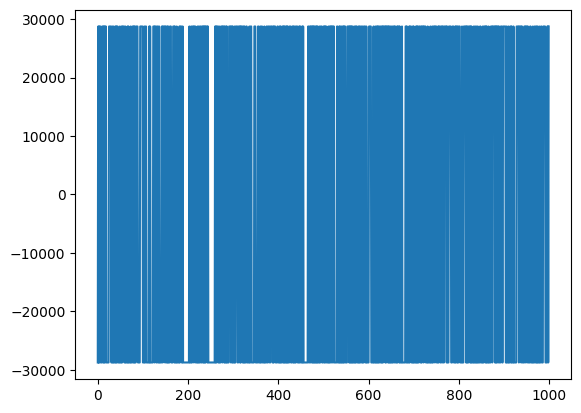

In [100]:
plt.plot(Signal[:,0])